In [15]:
#Se cargan las librearias 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

#se carga la imagen
original = Image.open("prueba.jpg")
baseDeformante = Image.open("gotas.jpg")
      
print(original.size)

(736, 736)


In [16]:


#Se cargan las librearias 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

#se carga la imagen
original = Image.open("prueba.jpg")
baseDeformante = Image.open("gotas.jpg")
      
print(original.size)

(736, 736, 3)


In [17]:

def convertirEscalaGrises(I):
#Se crea una copia de la imagen original
    arregloImagen = np.asarray(I)
    imagenTransformada = np.copy(arregloImagen)
    #Se obtiene el tamaño de la imagen
    n,m = I.size
    #Se convierte en escala de grises
    for x in range(0,m):
        for y in range(0,n):
            imagenTransformada[x,y,0] = 0.21*imagenTransformada[x,y,0]+0.72*imagenTransformada[x,y,1]+0.07*imagenTransformada[x,y,2]
            imagenTransformada[x,y,1] = imagenTransformada[x,y,0]
            imagenTransformada[x,y,2] = imagenTransformada[x,y,0]
    return Image.fromarray(imagenTransformada)

#S(x,y):= a * e^-((x-cx)^2+(y-cy)^2)/σ^2
def crearimgApretarPinchar(cx, cy, sigma, width, height):
    image = np.zeros((width, height, 3))
    
    #Se genera la iamgen dada la fórmula 
    for x in range(width):
        for y in range(height):
            value = np.exp(-((x-cx)**2+(y-cy)**2)/sigma**2)
            image[x, y, 0] = value
            image[x, y, 1] = value
            image[x, y, 2] = value
    
    #se desnormaliza la imagen
    image = image * 255
    image = image.astype(int)
    
    return image

def crearExtendida(f):
    filasfg = f.shape[0] + rows - 1
    columnasfg = f.shape[1] + cols - 1
    filasExt = f.shape[0] + 2*(rows - 1)
    columnasExt = f.shape[1] + 2*(cols - 1)
    fExt = np.zeros((filasExt,columnasExt,3))
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            fExt[i+rows-1][j+cols-1][0] = f[i][j][0]
            fExt[i+rows-1][j+cols-1][1] = f[i][j][1]
            fExt[i+rows-1][j+cols-1][2] = f[i][j][2]
    return fExt, filasfg, columnasfg
        
def saturacion(c):
    return max(0, min(255, c))



#se define la función que realiza la convolución
def convolution(fExt, filasfg , columnasfg , rows, cols, g):
    #Se define la matriz resultante de la convolución
    resultante = np.zeros((filasfg,columnasfg, 3))
    for i in range(filasfg):
        for j in range(columnasfg):
            sumaR = 0
            sumaG = 0
            sumaB = 0
            for k in range(rows):
                for l in range(cols):
                    sumaR = sumaR + fExt[i+k][j+l][0]*g[k][l]
                    sumaG = sumaG + fExt[i+k][j+l][1]*g[k][l]
                    sumaB = sumaB + fExt[i+k][j+l][2]*g[k][l]

            resultante[i][j][0] = saturacion(sumaR)
            resultante[i][j][1] = saturacion(sumaG)
            resultante[i][j][2] = saturacion(sumaB)
    return resultante


def transformacion(A, S, G_x, G_y, a):
    MapaX = np.zeros((A.shape[0], A.shape[1]), dtype=int)
    MapaY = np.zeros((A.shape[0], A.shape[1]), dtype=int)
    R = np.zeros((A.shape[0], A.shape[1], 3), dtype=int)
    
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            valorX = int((i + a * S[i][j][0] * G_x[i][j][0]))
            valorY = int((j + a * S[i][j][0] * G_y[i][j][0]))
            
            if valorX >= A.shape[0]:
                valorX = A.shape[0] - 1
            if valorY >= A.shape[1]:
                valorY = A.shape[1] - 1
            if valorX < 0:
                valorX = 0
            if valorY < 0:
                valorY = 0
                
            MapaX[i][j] = valorX
            MapaY[i][j] = valorY
            R[i][j][0] = A[MapaX[i][j]][MapaY[i][j]][0]
            R[i][j][1] = A[MapaX[i][j]][MapaY[i][j]][1]
            R[i][j][2] = A[MapaX[i][j]][MapaY[i][j]][2]

    

    return R



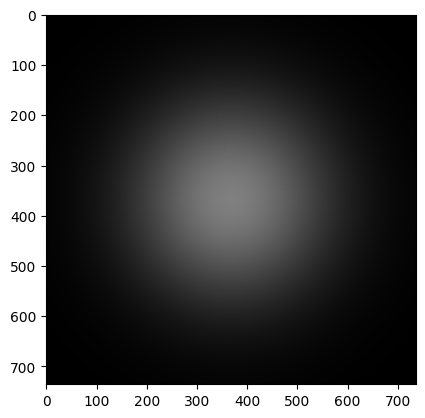

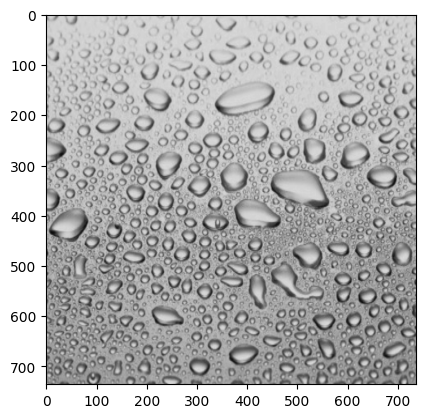

In [29]:
baseDeformante = convertirEscalaGrises(baseDeformante)
 
imgPinchar = crearimgApretarPinchar(original.shape[0]//2, original.shape[1]//2, 200,  original.shape[0] , original.shape[1] )
imgEstirar = imgPinchar.copy()
imgBaseDeformante = cv2.resize( np.array(baseDeformante), (original.shape[0], original.shape[1]), interpolation = cv2.INTER_AREA)   


extPinchar, filasfgP , columnasfgP = crearExtendida(imgPinchar)
extEstirar, filasfgE , columnasfgE = crearExtendida(imgEstirar)
extbaseDeformante, filasfgB , columnasfgB = crearExtendida(imgBaseDeformante)


GxP = convolution(extPinchar, filasfgP , columnasfgP, rows, cols, Sx)
GyP = convolution(extPinchar, filasfgP , columnasfgP, rows, cols, Sy)

GxE = convolution(extEstirar, filasfgE , columnasfgE, rows, cols, Sx)
GyE = convolution(extEstirar, filasfgE , columnasfgE, rows, cols, Sy)

GxB = convolution(extbaseDeformante, filasfgB, columnasfgB,rows, cols,Sx)
GyB = convolution(extbaseDeformante, filasfgB, columnasfgB,rows, cols,Sy)

#imagen Pinchar y Estirar
plt.imshow(imgPinchar)
plt.show()

plt.imshow(imgBaseDeformante)
plt.show()

#bordes de la imagen de ondas en X e Y

#bordes de la imagen  pinchar/pinchar en X e Y
# plt.imshow(Image.fromarray(GxP.astype(np.uint8)) )
# plt.show()
# plt.imshow(Image.fromarray(GyP.astype(np.uint8)))
# plt.show()

# #bordes de la imagen que sirve de base deformante
# plt.imshow(Image.fromarray(GxB.astype(np.uint8)))
# plt.show()
# plt.imshow(Image.fromarray(GyB.astype(np.uint8)))
# plt.show()




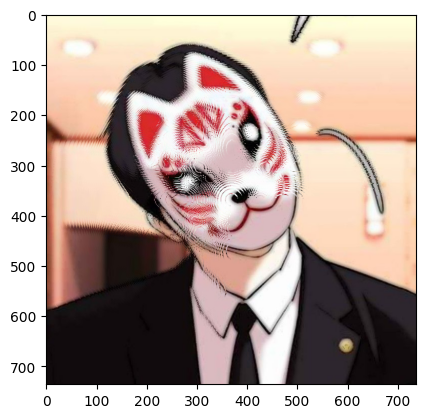

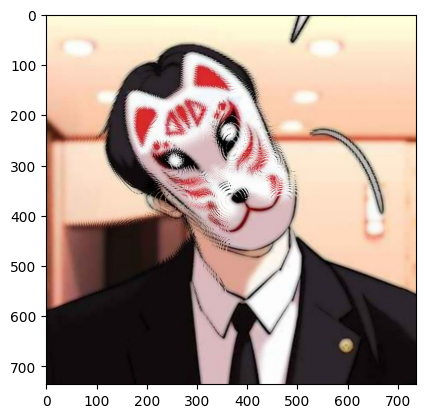

In [34]:

imgResultantePinchar = transformacion(original, extPinchar, GxP, GyP, -0.07)
imgResultanteEstirar = transformacion(original, extEstirar, GxE, GyE, 0.07)
#imgResultanteBaseDeformante = transformacion(original, extbaseDeformante, GxB, GyB, 0.0005) 

# plt.imshow(original)
# plt.show()

plt.show()
plt.imshow(imgResultantePinchar)
plt.show()
plt.imshow(imgResultanteEstirar)
plt.show()
# plt.imshow(imgResultanteBaseDeformante)
# plt.show()